In [1]:
import os
import sys
import pandas as pd
import math

os.chdir('./scripts')

import load_config
import matplotlib.pyplot as plt
import sweetviz as sv
import numpy as np
import seaborn as sns
import datetime

In [ ]:
os.getcwd()

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [3]:
config = load_config.load_config_const()
plt.style.use('seaborn')

In [33]:
config['files_dgt']

['export_anual_trf_2015.csv.tar.gz',
 'export_anual_trf_2016.csv.tar.gz',
 'export_anual_trf_2017.csv.tar.gz',
 'export_anual_trf_2018.csv.tar.gz',
 'export_anual_trf_2019.csv.tar.gz',
 'export_anual_trf_2020.csv.tar.gz',
 'export_anual_trf_2021.csv.tar.gz']

# Estudio del Dataset de transacciones de turismos de la DGT

El presente notebook tiene como objetivo hace un estudio de las características relevantes del dataset de transferencias de turismos.

## 1. Carga de datos

Debido al pandas, al convertir los datos en un dataframe, el campo de código postal es convertido en tipo númerico float o integer. Es necesario reconstruir los códigos.

In [34]:
def cod_postal_zero_int_repair(cod_postal):
    if (not math.isnan( cod_postal )):
        cod_postal = int(cod_postal)
        if ( len(str(cod_postal)) == 5 ):
            return str(cod_postal)
        elif ( len(str(int(cod_postal))) == 4 ):
            return '0'+str(int(cod_postal))
        else:
            return int(cod_postal)
    else:
        return cod_postal

La siguiente función se usa para obtener el código de provincia del código postal

In [6]:
def return_id_province_by_zip(cod_postal):
    if (cod_postal):
        cod_postal = str(cod_postal)
        return cod_postal[0:2]
    else:
        return cod_postal

is_weekend se usa para obtener si el día del traspaso es fin de semana, ya que, como se verá más adelante, estos días los traspasos de vehículos son mínimos. Interesante conocer esto para implementar la serie temporal y obtener una predición más fiable.

In [7]:
def is_weekend(day_week):
    if (day_week == 'Saturday' or day_week == 'Sunday'):
        return True
    else:
        return False

Crea una correspondencia de código de provincia y su nombre

In [9]:
def return_province(id_province):
    list_ids_province = {
        '01': 'Álava',
        '08': 'Barcelona',
        '15': 'La Coruña',
        '23': 'Jaén',
        '30': 'Murcia',
        '38': 'Santa Cruz de Tenerife',
        '45': 'Toledo',
        '02': 'Albacete',
        '09': 'Burgos',
        '16': 'Cuenca',
        '24': 'León',
        '31': 'Navarra',
        '46': 'Valencia',
        '03': 'Alicante',
        '10': 'Cáceres',
        '17': 'Gerona',
        '25': 'Lérida',
        '32': 'Orense',
        '39': 'Cantabria',
        '47': 'Valladolid',
        '04': 'Almería',
        '11': 'Cádiz',
        '18': 'Granada',
        '26': 'La Rioja',
        '33': 'Asturias',
        '40': 'Segovia',
        '48': 'Vizcaya',
        '05': 'Ávila',
        '12': 'Castellón',
        '19': 'Guadalajara',
        '34': 'Palencia',
        '41': 'Sevilla',
        '49': 'Zamora',
        '06': 'Badajoz',
        '13': 'Ciudad Real',
        '20': 'Guipúzcoa',
        '27': 'Lugo',
        '35': 'Las Palmas',
        '42': 'Soria',
        '50': 'Zaragoza',
        '07': 'Islas Baleares',
        '21': 'Huelva',
        '28': 'Madrid',
        '36': 'Pontevedra',
        '43': 'Tarragona',
        '51': 'Ceuta',
        '14': 'Córdoba',
        '22': 'Huesca',
        '29': 'Málaga',
        '37': 'Salamanca',
        '44': 'Teruel',
        '52': 'Melilla'
    }
    
    return list_ids_province.get(id_province)

Debido a que algunas marcas se dan de alta con distinto nombre, es requerido una forma de unificar las marcas y así ser más preciso a la hora de contabilizar los traspasos por marca

In [10]:
def return_make(make):
    list_makes = {
        'ABARTH': 'ABARTH',
        'ALFA': 'ALFA ROMEO',
        'ALFA ROMEO': 'ALFA ROMEO',
        'ASTON MARTIN': 'ASTON MARTIN',
        'AUDI': 'AUDI',
        'BENTLEY': 'BENTLEY',
        'BMW': 'BMW',
        'BMW I': 'BMW',
        'CADILLAC': 'CADILLAC',
        'CHEVROLET': 'CHEVROLET',
        'CHRYSLER': 'CHRYSLER',
        'CITROEN': 'CITROEN',
        'CUPRA': 'CUPRA',
        'DACIA': 'DACIA',
        'DAEWOO': 'DAEWOO',
        'DAIHATSU': 'DAIHATSU',
        'DAIMLER': 'DAIMLER',
        'DAIMLER AG': 'DAIMLER',
        'DAIMLER CHRYSLER': 'CHRYSLER',
        'DODGE': 'DODGE',
        'DS': 'DS',
        'FERRARI': 'FERRARI',
        'FIAT': 'FIAT',
        'FORD': 'FORD',
        'FORD CNG TECHNIK': 'FORD',
        'FORD-CNG-TECHNIK': 'FORD',
        'GMC': 'GMC',
        'HONDA': 'HONDA',
        'HUMMER': 'HUMMER',
        'HYUNDAI': 'HYUNDAI',
        'INFINITI': 'INFINITI',
        'ISUZU': 'ISUZU',
        'IVECO': 'IVECO',
        'JAGUAR': 'JAGUAR',
        'JAGUAR LAND ROVER LIMIT': 'LAND-ROVER',
        'JEEP': 'JEEP',
        'KIA': 'KIA',
        'LADA': 'LADA',
        'LAMBORGHINI': 'LAMBORGHINI',
        'LANCIA': 'LANCIA',
        'LAND ROVER': 'LAND-ROVER',
        'LEXUS': 'LEXUS',
        'LOTUS': 'LOTUS',
        'M.G': 'MG',
        'MAHINDRA': 'MAHINDRA',
        'MASERATI': 'MASERATI',
        'MAZDA': 'MAZDA',
        'MCC SMART': 'SMART',
        'MCLAREN': 'MCLAREN',
        'MERCEDES': 'MERCEDES-BENZ',
        'MERCEDES-AMG': 'MERCEDES-BENZ',
        'MERCEDES-BENZ': 'MERCEDES-BENZ',
        'MG': 'MG',
        'MICRO COMPACT CAR': 'SMART',
        'MINI': 'MINI',
        'MITSUBISHI': 'MITSUBISHI',
        'NISSAN': 'NISSAN',
        'OPEL': 'OPEL',
        'PEUGEOT': 'PEUGEOT',
        'PORSCHE': 'PORSCHE',
        'QUATTRO': 'AUDI',
        'RANGE ROVER': 'ROVER',
        'RENAULT': 'RENAULT',
        'ROVER': 'ROVER',
        'SAAB': 'SAAB',
        'SANTANA': 'SANTANA',
        'SEAT': 'SEAT',
        'SEAT FIAT': 'SEAT',
        'SKODA': 'SKODA',
        'SMART': 'SMART',
        'SSANGYONG': 'SSANGYONG',
        'SUBARU': 'SUBARU',
        'SUZUKI': 'SUZUKI',
        'SUZUKI SANTANA': 'SANTANA',
        'TATA': 'TATA',
        'TESLA': 'TESLA',
        'TESLA MOTORS': 'TESLA',
        'TOYOTA': 'TOYOTA',
        'VOLKSWAGEN': 'VOLKSWAGEN',
        'VOLKSWAGEN V W': 'VOLKSWAGEN',
        'VOLVO': 'VOLVO',
    }
    
    return list_makes.get(make)

In [11]:
def return_avaliable_makes():
    return [
        'ABARTH',
        'ALFA',
        'ALFA ROMEO',
        'ASTON MARTIN',
        'AUDI',
        'BENTLEY',
        'BMW',
        'BMW I',
        'CADILLAC',
        'CHEVROLET',
        'CHRYSLER',
        'CITROEN',
        'CUPRA',
        'DACIA',
        'DAEWOO',
        'DAIHATSU',
        'DAIMLER',
        'DAIMLER AG',
        'DAIMLER CHRYSLER',
        'DODGE',
        'DS',
        'FERRARI',
        'FIAT',
        'FORD',
        'FORD CNG TECHNIK',
        'FORD-CNG-TECHNIK',
        'GMC',
        'HONDA',
        'HUMMER',
        'HYUNDAI',
        'INFINITI',
        'ISUZU',
        'IVECO',
        'JAGUAR',
        'JAGUAR LAND ROVER LIMIT',
        'JEEP',
        'KIA',
        'LADA',
        'LAMBORGHINI',
        'LANCIA',
        'LAND ROVER',
        'LEXUS',
        'LOTUS',
        'M.G',
        'MAHINDRA',
        'MASERATI',
        'MAZDA',
        'MCC SMART',
        'MCLAREN',
        'MERCEDES',
        'MERCEDES-AMG',
        'MERCEDES-BENZ',
        'MG',
        'MICRO COMPACT CAR',
        'MINI',
        'MITSUBISHI',
        'NISSAN',
        'OPEL',
        'PEUGEOT',
        'PORSCHE',
        'QUATTRO',
        'RANGE ROVER',
        'RENAULT',
        'ROVER',
        'SAAB',
        'SANTANA',
        'SEAT',
        'SEAT FIAT',
        'SKODA',
        'SMART',
        'SSANGYONG',
        'SUBARU',
        'SUZUKI',
        'SUZUKI SANTANA',
        'TATA',
        'TESLA',
        'TESLA MOTORS',
        'TOYOTA',
        'VOLKSWAGEN',
        'VOLKSWAGEN V W',
        'VOLVO'
    ]

Este el proceso principal donde se carga el dataframe con todos los archivos de la dgt por años. Al ser un número muy alto de registros, se accede a una fracción de los mismos. Igualmente, se realiza una serie de procedimientos para limpìar campos, estandarizarlos o eliminar aquellos valorer Nan que no pueden rellenarse con otros valores

In [12]:
columns = config['fields_dgt_process']


df = '';

for dgt_file in config['files_dgt']:

    route_file = config['base_route'] + config['data_route'] +  config['data_dgt_route'] + '/' + dgt_file
    
    print(f'Processing {dgt_file}')
    
    df_aux = pd.read_csv(route_file, compression='gzip', sep=config['csv_dgt_separator'], low_memory=False)
    df_aux.columns = columns
    
    
    df_aux = df_aux.sample(frac=0.4)
    
    
    df_aux['FEC_MATRICULA'] = pd.to_datetime(df_aux['FEC_MATRICULA'])
    df_aux['FEC_TRAMITACION'] = pd.to_datetime(df_aux['FEC_TRAMITACION'])
    df_aux['FEC_TRAMITE'] = pd.to_datetime(df_aux['FEC_TRAMITE'])
    df_aux['FEC_PRIM_MATRICULACION'] = pd.to_datetime(df_aux['FEC_PRIM_MATRICULACION'])
    
    
    df_aux = df_aux[df_aux['MARCA_ITV'].isin( return_avaliable_makes() )]
    df_aux['MARCA_ITV'] = df_aux['MARCA_ITV'].apply(lambda x: return_make(x) )
    df_aux = df_aux[df_aux['MARCA_ITV'] != '']
    
    
    df_aux['Q_query'] = df_aux['Q_query'].apply(lambda x: int(x) if not math.isnan(x) else x )
    df_aux['year_Q'] = df_aux['year_Q'].apply(lambda x: int(x) if not math.isnan(x) else x )
    df_aux['CODIGO_POSTAL'] = df_aux['CODIGO_POSTAL'].apply(lambda x: int(x) if not math.isnan(x) else x )
    df_aux['CLAVE_TRAMITE'] = df_aux['CLAVE_TRAMITE'].apply(lambda x: int(x) if not math.isnan(x) else x )
    df_aux['NUM_TRANSMISIONES'] = df_aux['NUM_TRANSMISIONES'].apply(lambda x: int(x) if not math.isnan(x) else x )
    df_aux['NUM_PLAZAS'] = df_aux['NUM_PLAZAS'].apply(lambda x: int(x) if not math.isnan(x) else x )
    df_aux['NUM_TITULARES'] = df_aux['NUM_TITULARES'].apply(lambda x: int(x) if not math.isnan(x) else x )
    df_aux['CILINDRADA_ITV'] = df_aux['CILINDRADA_ITV'].apply(lambda x: int(x) if not math.isnan(x) else x )
    df_aux['COD_MUNICIPIO_INE_VEH'] = df_aux['COD_MUNICIPIO_INE_VEH'].apply(lambda x: int(x) if not math.isnan(x) else x )
    # df_aux['KW_ITV'] = df_aux['KW_ITV'].apply(lambda x: int(x) if not math.isnan(x) else x )
    df_aux['NUM_PLAZAS_MAX'] = df_aux['NUM_PLAZAS_MAX'].apply(lambda x: int(x) if not math.isnan(x) else x )
    df_aux['CO2_ITV'] = df_aux['CO2_ITV'].apply(lambda x: int(x) if not math.isnan(x) else x )
    
    df_aux['CODIGO_POSTAL'] = df_aux['CODIGO_POSTAL'].apply(lambda x: cod_postal_zero_int_repair(x) )
    df_aux['COD_MUNICIPIO_INE_VEH'] = df_aux['COD_MUNICIPIO_INE_VEH'].apply(lambda x: cod_postal_zero_int_repair(x) )
    df_aux['ID_MUNICIPIO'] = df_aux['COD_MUNICIPIO_INE_VEH'].apply(lambda x: return_id_province_by_zip(x) )
    
    df_aux = df_aux[df_aux['FEC_TRAMITACION'] >= '2015-01-01 00:00:00']
    df_aux = df_aux[df_aux['FEC_TRAMITACION'] <= '2021-12-31 23:59:59']
    
    df_aux = df_aux[df_aux['FEC_TRAMITE'] >= '2015-01-01 00:00:00']
    df_aux = df_aux[df_aux['FEC_TRAMITE'] <= '2021-12-31 23:59:59']
    
    df_aux['ID_MUNICIPIO'].fillna(value=np.nan, inplace=True)
    
    df_aux = df_aux[df_aux['ID_MUNICIPIO'].notna()]
    df_aux = df_aux[df_aux['year_Q'].notna()]
    
    df_aux = df_aux[df_aux['ID_MUNICIPIO'] != 0]
    
    df_aux['year_Q'] = df_aux['year_Q'].apply(lambda x: int(x) if not math.isnan(x) else x )
    df_aux['Q_query'] = df_aux['Q_query'].apply(lambda x: int(x) if not math.isnan(x) else x )

    df_aux['month_year_Q'] = df_aux['FEC_TRAMITE'].dt.month
    
    index = df_aux.index
    number_of_rows = len(index)
    print(f'### Lines -> {number_of_rows}')
    
    if (type(df) == pd.core.frame.DataFrame):
        print('### Merge with main datagrame')
        df = pd.concat([df,df_aux]);
    else:
        print('### Create main datagrame')
        
        df = df_aux.copy()
        
    del df_aux
    
    index = df.index
    number_of_rows = len(index)
    print(f'### Total lines -> {number_of_rows}')

Processing export_anual_trf_2015.csv.tar.gz
### Lines -> 902040
### Create main datagrame
### Total lines -> 902040
Processing export_anual_trf_2016.csv.tar.gz
### Lines -> 981076
### Merge with main datagrame
### Total lines -> 1883116
Processing export_anual_trf_2017.csv.tar.gz
### Lines -> 1095284
### Merge with main datagrame
### Total lines -> 2978400
Processing export_anual_trf_2018.csv.tar.gz
### Lines -> 1171626
### Merge with main datagrame
### Total lines -> 4150026
Processing export_anual_trf_2019.csv.tar.gz
### Lines -> 1186237
### Merge with main datagrame
### Total lines -> 5336263
Processing export_anual_trf_2020.csv.tar.gz
### Lines -> 1003392
### Merge with main datagrame
### Total lines -> 6339655
Processing export_anual_trf_2021.csv.tar.gz
### Lines -> 1119053
### Merge with main datagrame
### Total lines -> 7458708


In [13]:
df.sample(10)

,FEC_MATRICULA,COD_CLASE_MAT,FEC_TRAMITACION,MARCA_ITV,MODELO_ITV,COD_PROCEDENCIA_ITV,COD_PROPULSION_ITV,CILINDRADA_ITV,POTENCIA_ITV,NUM_PLAZAS,NUM_TRANSMISIONES,NUM_TITULARES,LOCALIDAD_VEHICULO,COD_PROVINCIA_VEH,COD_PROVINCIA_MAT,CLAVE_TRAMITE,FEC_TRAMITE,CODIGO_POSTAL,FEC_PRIM_MATRICULACION,IND_NUEVO_USADO,PERSONA_FISICA_JURIDICA,COD_MUNICIPIO_INE_VEH,MUNICIPIO,KW_ITV,NUM_PLAZAS_MAX,CO2_ITV,RENTING,CATEGORÍA_HOMOLOGACIÓN_EUROPEA_ITV,NIVEL_EMISIONES_EURO_ITV,CONSUMO_WH/KM_ITV,CATEGORÍA_VEHÍCULO_ELÉCTRICO,AUTONOMÍA_VEHÍCULO_ELÉCTRICO,year_Q,Q_query,ID_MUNICIPIO,month_year_Q
1627955,2015-02-25,0.0,2015-11-26,BMW,320D,3.0,1,1995,13.29,5,2,1,NaN,M,M,2,2015-10-05,28180,NaT,N,X,28151,TORRELAGUNA,135.00,5,118.0,N,M1,EURO 5J,0.0,NaN,0.0,2015,4,28,10
1890660,2019-05-31,0.0,2019-08-29,SEAT,LEON ST,3.0,0,1498,11.19,5,1,1,NaN,B,B,2,2019-08-29,08917,NaT,N,D,08015,BADALONA,96.00,5,113.0,N,M1,EURO 6AG,0.0,NaN,0.0,2019,3,08,8
1345857,2003-02-11,0.0,2019-06-18,KIA,KIA SHUMA II,1.0,0,1594,11.00,5,1,1,AGUADULCE,AL,AL,2,2019-06-18,04720,NaT,N,D,04079,ROQUETAS DE MAR,0.00,5,NaN,N,M1,EURO 3,0.0,NaN,NaN,2019,2,04,6
1129506,2007-05-28,0.0,2019-05-23,BMW,318D BERLINA,3.0,1,1995,13.30,5,4,1,NaN,SE,M,2,2019-05-23,41007,NaT,N,D,41091,SEVILLA,90.00,5,NaN,N,M1,EURO 4,0.0,NaN,NaN,2019,2,41,5
2793865,2006-10-27,0.0,2021-12-29,RENAULT,LAGUNA,3.0,1,1870,0.13,5,3,1,NaN,PO,M,2,2021-12-29,36315,NaT,N,D,36057,VIGO,96.00,5,NaN,N,M1,EURO 4B,0.0,NaN,NaN,2021,4,36,12
1626066,2021-07-28,0.0,2021-08-02,VOLKSWAGEN,GOLF,3.0,0,999,7.82,5,1,1,NaN,TO,TO,2,2021-08-02,45800,NaT,N,X,45142,QUINTANAR DE ORDEN,81.00,5,118.0,N,M1,EURO 6AP,0.0,HEV,0.0,2021,3,45,8
1458180,2013-10-15,0.0,2015-09-07,SKODA,FABIA,3.0,0.0,1197,9.78,5,1,1,NaN,GC,GC,2,2015-09-07,35250,NaT,N,D,35011,INGENIO,63.00,5,119.0,N,M1,EURO 5,0.0,NaN,NaN,2015,3,35,9
1437837,2010-07-01,0.0,2020-09-09,FIAT,FIAT PANDA,3.0,0,1242,10.00,5,4,1,NaN,GC,GC,2,2020-08-27,35400,NaT,N,D,35006,ARUCAS,10.00,5,NaN,N,M1,EURO 4,0.0,NaN,NaN,2020,3,35,8
2225369,2003-12-29,0.0,2020-12-04,BMW,320TD MAN,3.0,1.0,1995,13.30,5,7,1,NaN,M,M,2,2020-11-27,28033,NaT,N,D,28079,MADRID,0.00,5,NaN,N,M1,EURO 3,0.0,NaN,NaN,2020,4,28,11
1137496,2010-11-30,0.0,2016-06-22,FORD,FOCUS,0.0,1,1560,11.47,5,2,1,NaN,IB,IB,2,2016-06-22,07350,NaT,N,D,07008,BINISSALEM,80.00,5,119.0,N,M1,EURO 4,0.0,NaN,NaN,2016,2,07,6


Comprobamos el tamaño del dataframe obtenido luego del proceso

In [14]:
len(df.index)

7458708

Así como comprobamos los tipos de las columnas

In [15]:
df.dtypes

FEC_MATRICULA                         datetime64[ns]
COD_CLASE_MAT                                float64
FEC_TRAMITACION                       datetime64[ns]
MARCA_ITV                                     object
MODELO_ITV                                    object
COD_PROCEDENCIA_ITV                          float64
COD_PROPULSION_ITV                            object
CILINDRADA_ITV                                 int64
POTENCIA_ITV                                 float64
NUM_PLAZAS                                     int64
NUM_TRANSMISIONES                              int64
NUM_TITULARES                                  int64
LOCALIDAD_VEHICULO                            object
COD_PROVINCIA_VEH                             object
COD_PROVINCIA_MAT                             object
CLAVE_TRAMITE                                  int64
FEC_TRAMITE                           datetime64[ns]
CODIGO_POSTAL                                 object
FEC_PRIM_MATRICULACION                datetime

Analizamos los campos, tanto su matriz de correlación como el contenido de cada uno de los campos con la herramienta "sweetviz". Nos permite sacar un dossier de información muy completo ahorrando la implementación de código para ello

In [ ]:
my_report = sv.analyze(df)
my_report.show_notebook()

## 2. Analisis de campos

### 2.1 Fecha de tramite

Mediante la agrupación de la fecha de tramite, se obtendrá el número de traspasos diarios. Importante para la obtención de la serie temporal más adelante

In [16]:
df.groupby(['FEC_TRAMITE']).size().reset_index(name='counts')

,FEC_TRAMITE,counts
0,2015-01-01,1
1,2015-01-02,1004
2,2015-01-03,4
3,2015-01-04,37
4,2015-01-05,1624
...,...,...
2407,2021-12-27,7359
2408,2021-12-28,6402
2409,2021-12-29,7354
2410,2021-12-30,7331


Mostramos mediante una gráfica el las ventas por fecha, pudiendo reconocer a simple vista una serie de patrones

<AxesSubplot:xlabel='FEC_TRAMITE', ylabel='counts'>

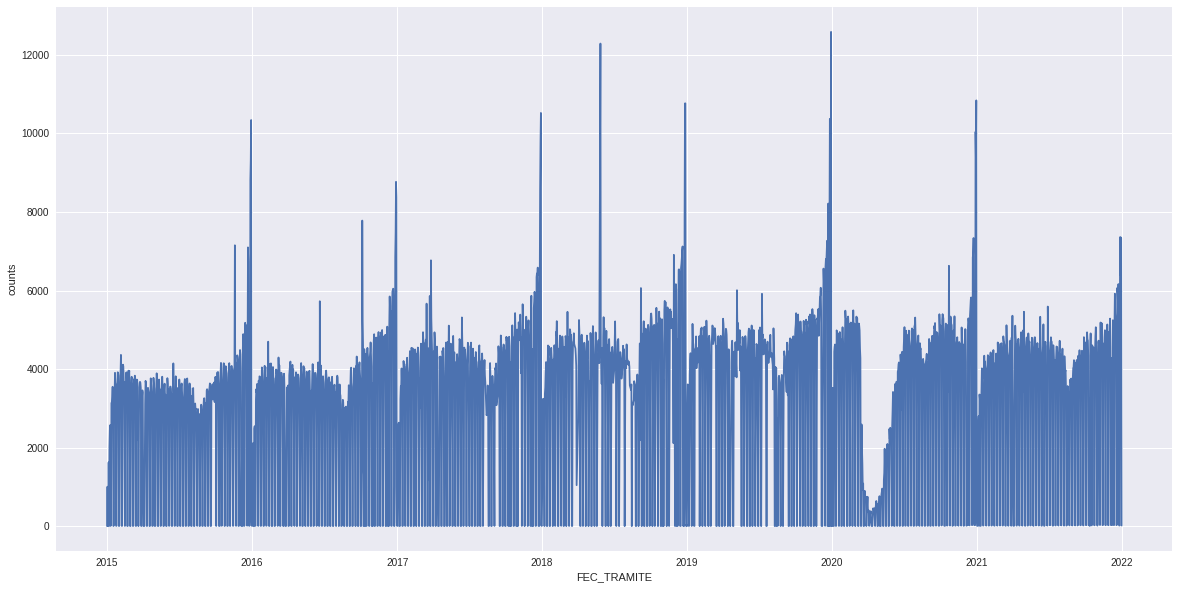

In [17]:
fig, ax = plt.subplots(figsize=(20,10))
grouped = df.groupby(['FEC_TRAMITE']).size().reset_index(name='counts')

sns.lineplot(data=grouped, x='FEC_TRAMITE', y='counts')

La primera característica apreciable es que cada fin de año, el número de traspasos aumenta exponencialmente. Esto puede ser debido tanto a las fiestas, pagas extraordinarias o a la finalización de algún tipo de año fiscal, pero es algo frecuente todos los años.

En la época de verano, más concretamente en agosto, también se puede apreciar algo que se repite todos los años, una pequeña bajada en los traspasos de vehículos. No es una bajada importante, pero si es caracteristica del periodo.

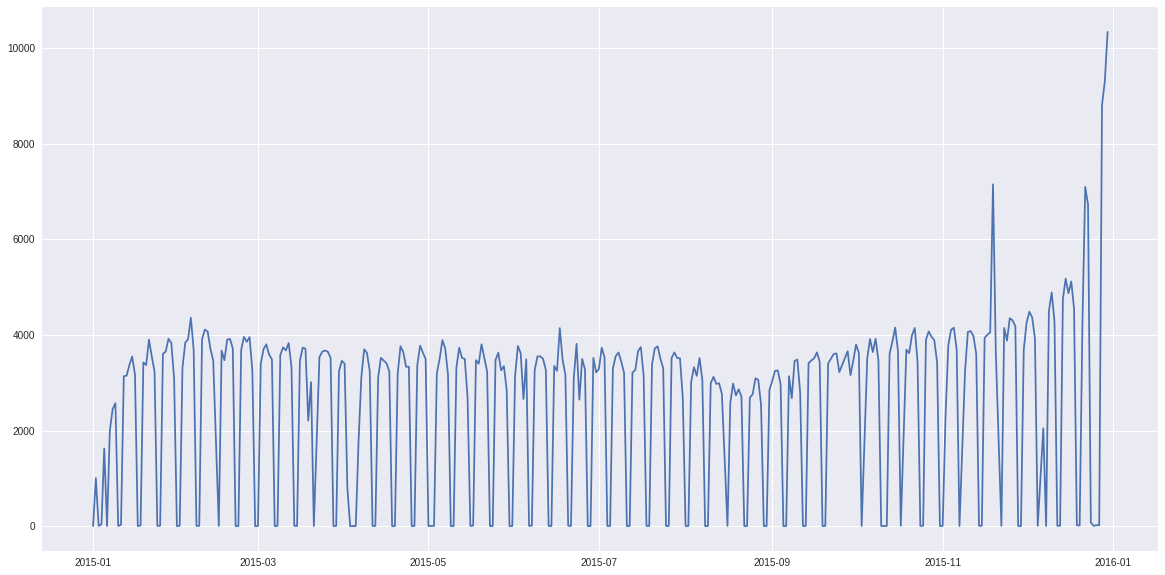

In [36]:
fig, ax = plt.subplots(figsize=(20,10))
grouped = df.groupby(['FEC_TRAMITE']).size().reset_index(name='counts')

plt.plot(
    grouped[(grouped['FEC_TRAMITE'] >= '2015-01-01') & (grouped['FEC_TRAMITE'] < '2015-12-31')]['FEC_TRAMITE'],
    grouped[(grouped['FEC_TRAMITE'] >= '2015-01-01') & (grouped['FEC_TRAMITE'] < '2015-12-31')]['counts']
)

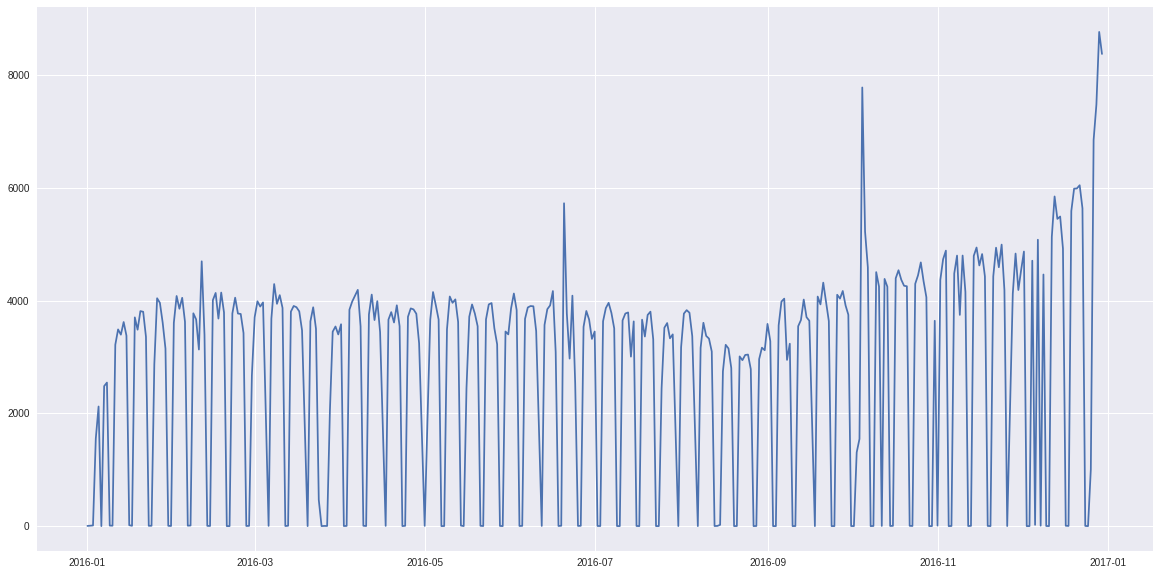

In [37]:
fig, ax = plt.subplots(figsize=(20,10))
grouped = df.groupby(['FEC_TRAMITE']).size().reset_index(name='counts')

plt.plot(
    grouped[(grouped['FEC_TRAMITE'] >= '2016-01-01') & (grouped['FEC_TRAMITE'] < '2016-12-31')]['FEC_TRAMITE'],
    grouped[(grouped['FEC_TRAMITE'] >= '2016-01-01') & (grouped['FEC_TRAMITE'] < '2016-12-31')]['counts']
)

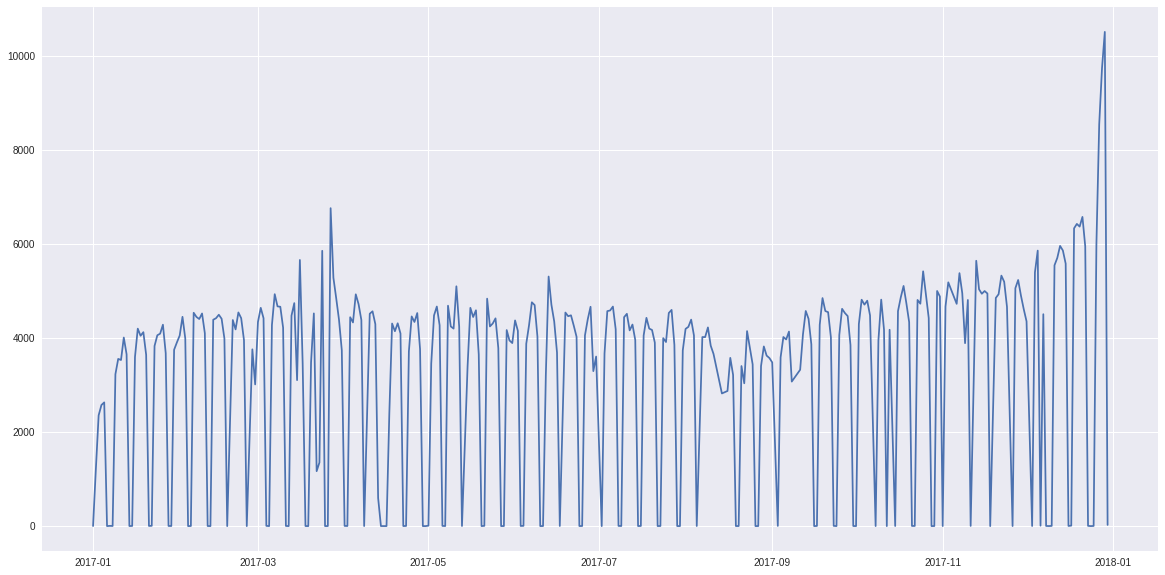

In [38]:
fig, ax = plt.subplots(figsize=(20,10))
grouped = df.groupby(['FEC_TRAMITE']).size().reset_index(name='counts')

plt.plot(
    grouped[(grouped['FEC_TRAMITE'] >= '2017-01-01') & (grouped['FEC_TRAMITE'] < '2017-12-31')]['FEC_TRAMITE'],
    grouped[(grouped['FEC_TRAMITE'] >= '2017-01-01') & (grouped['FEC_TRAMITE'] < '2017-12-31')]['counts']
)

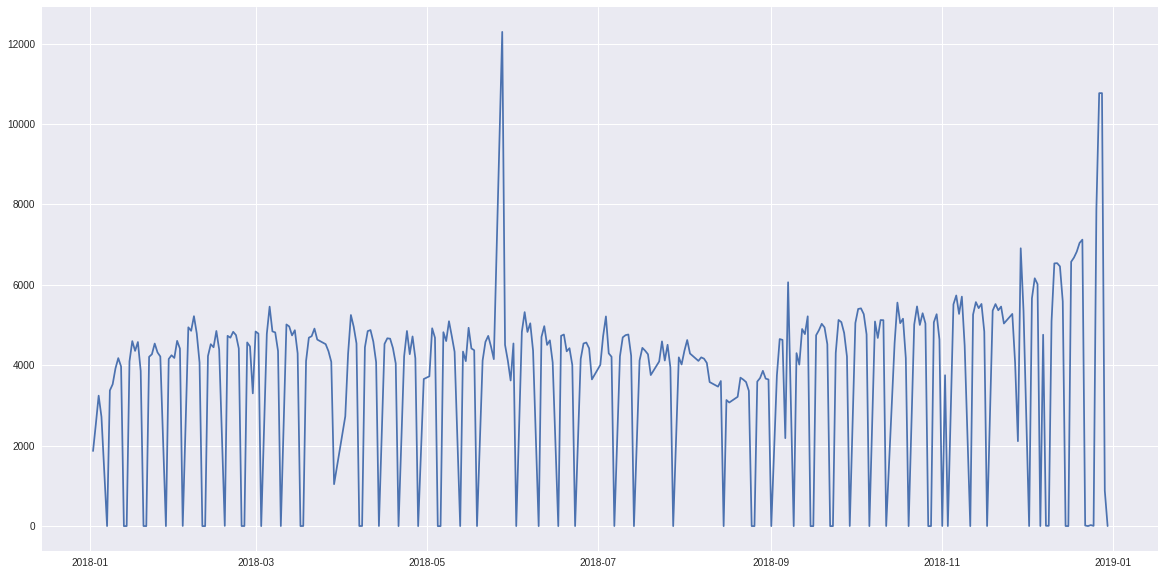

In [39]:
fig, ax = plt.subplots(figsize=(20,10))
grouped = df.groupby(['FEC_TRAMITE']).size().reset_index(name='counts')

plt.plot(
    grouped[(grouped['FEC_TRAMITE'] >= '2018-01-01') & (grouped['FEC_TRAMITE'] < '2018-12-31')]['FEC_TRAMITE'],
    grouped[(grouped['FEC_TRAMITE'] >= '2018-01-01') & (grouped['FEC_TRAMITE'] < '2018-12-31')]['counts']
)

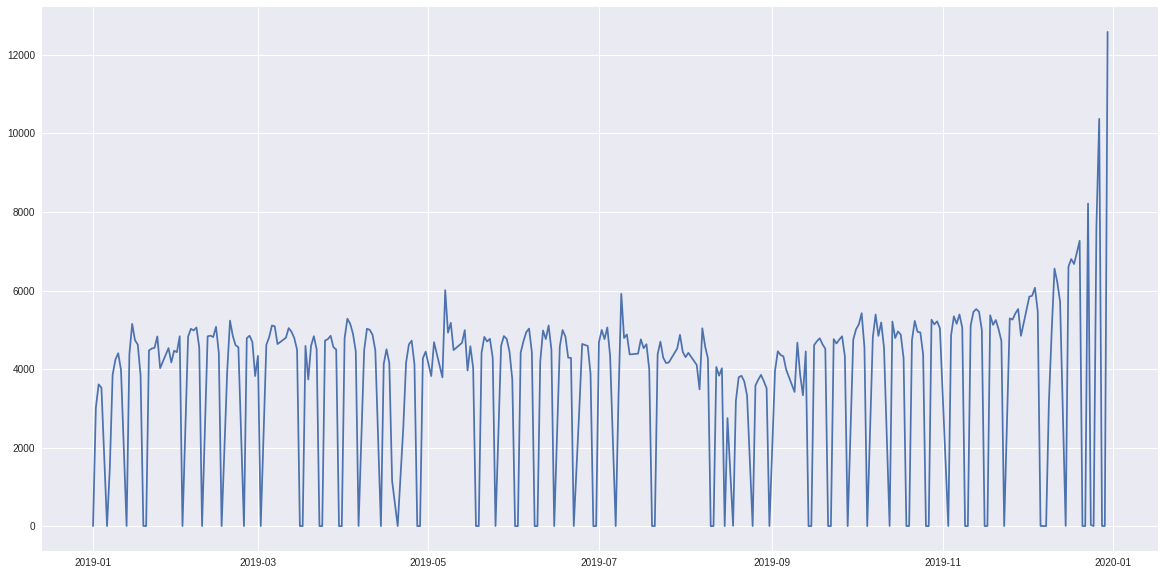

In [40]:
fig, ax = plt.subplots(figsize=(20,10))
grouped = df.groupby(['FEC_TRAMITE']).size().reset_index(name='counts')

plt.plot(
    grouped[(grouped['FEC_TRAMITE'] >= '2019-01-01') & (grouped['FEC_TRAMITE'] < '2019-12-31')]['FEC_TRAMITE'],
    grouped[(grouped['FEC_TRAMITE'] >= '2019-01-01') & (grouped['FEC_TRAMITE'] < '2019-12-31')]['counts']
)

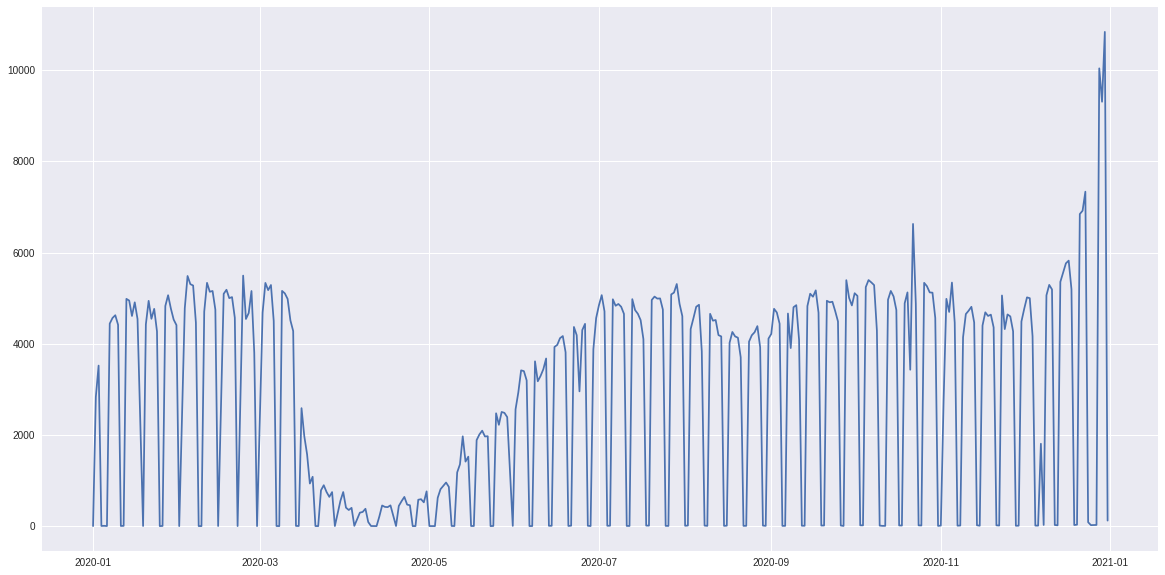

In [41]:
fig, ax = plt.subplots(figsize=(20,10))
grouped = df.groupby(['FEC_TRAMITE']).size().reset_index(name='counts')

plt.plot(
    grouped[(grouped['FEC_TRAMITE'] >= '2020-01-01') & (grouped['FEC_TRAMITE'] <= '2020-12-31')]['FEC_TRAMITE'],
    grouped[(grouped['FEC_TRAMITE'] >= '2020-01-01') & (grouped['FEC_TRAMITE'] <= '2020-12-31')]['counts']
)

El año del comienzo de la pandemia es muy notable el periodo de la cuarentena, habiendo una bajada extraordinaria de

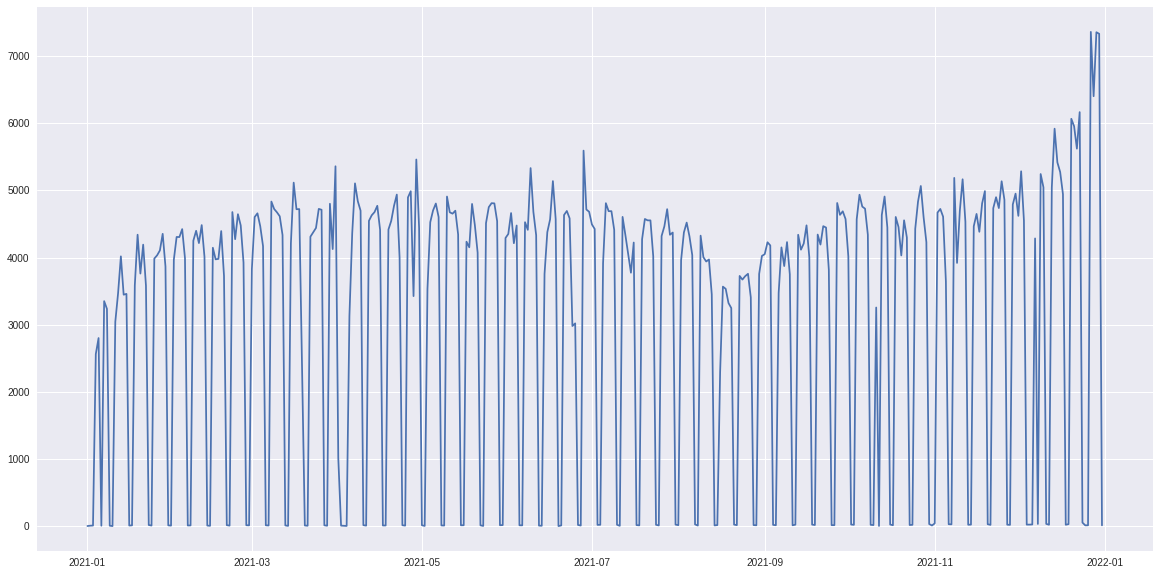

In [42]:
fig, ax = plt.subplots(figsize=(20,10))
grouped = df.groupby(['FEC_TRAMITE']).size().reset_index(name='counts')

plt.plot(
    grouped[(grouped['FEC_TRAMITE'] >= '2021-01-01') & (grouped['FEC_TRAMITE'] <= '2021-12-31')]['FEC_TRAMITE'],
    grouped[(grouped['FEC_TRAMITE'] >= '2021-01-01') & (grouped['FEC_TRAMITE'] <= '2021-12-31')]['counts']
)

<AxesSubplot:xlabel='day_of_year', ylabel='counts'>

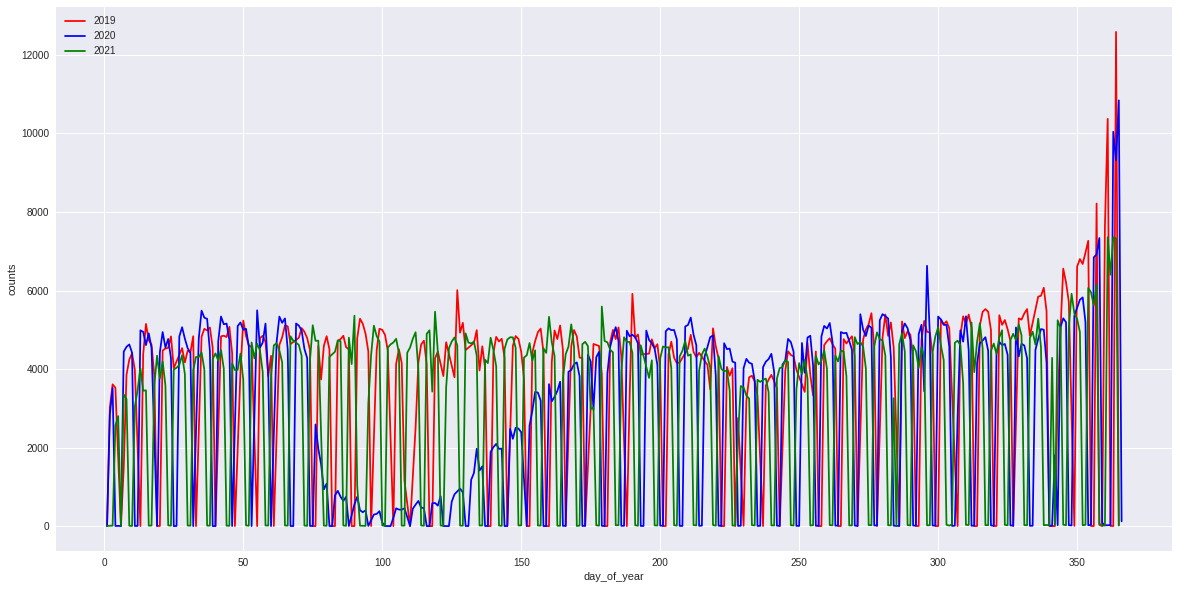

In [18]:
grouped = df.groupby(['FEC_TRAMITE']).size().reset_index(name='counts')

grouped['day_of_year'] = grouped['FEC_TRAMITE'].dt.dayofyear
grouped['year'] = grouped['FEC_TRAMITE'].dt.year

fig, ax = plt.subplots(figsize=(20,10))

#2019 -> red
sns.lineplot(data=grouped[(grouped['FEC_TRAMITE'] >= '2019-01-01') & (grouped['FEC_TRAMITE'] <= '2019-12-31')], x='day_of_year', y='counts', color='red', label='2019')
#2020 -> blue
sns.lineplot(data=grouped[(grouped['FEC_TRAMITE'] >= '2020-01-01') & (grouped['FEC_TRAMITE'] <= '2020-12-31')], x='day_of_year', y='counts', color='blue', label='2020')
#2020 -> green
sns.lineplot(data=grouped[(grouped['FEC_TRAMITE'] >= '2021-01-01') & (grouped['FEC_TRAMITE'] <= '2021-12-31')], x='day_of_year', y='counts', color='green', label='2021')




Al comparar el año de la pandemia con el año anterior y posterior, es curioso que, salvo el confinamiento estricto, no se observa una bajada con despecto a los otros años a lo largo del resto del año 

La siguiente representación corresponde a una vista de las transacciones en la época del confinamiento restrictivo

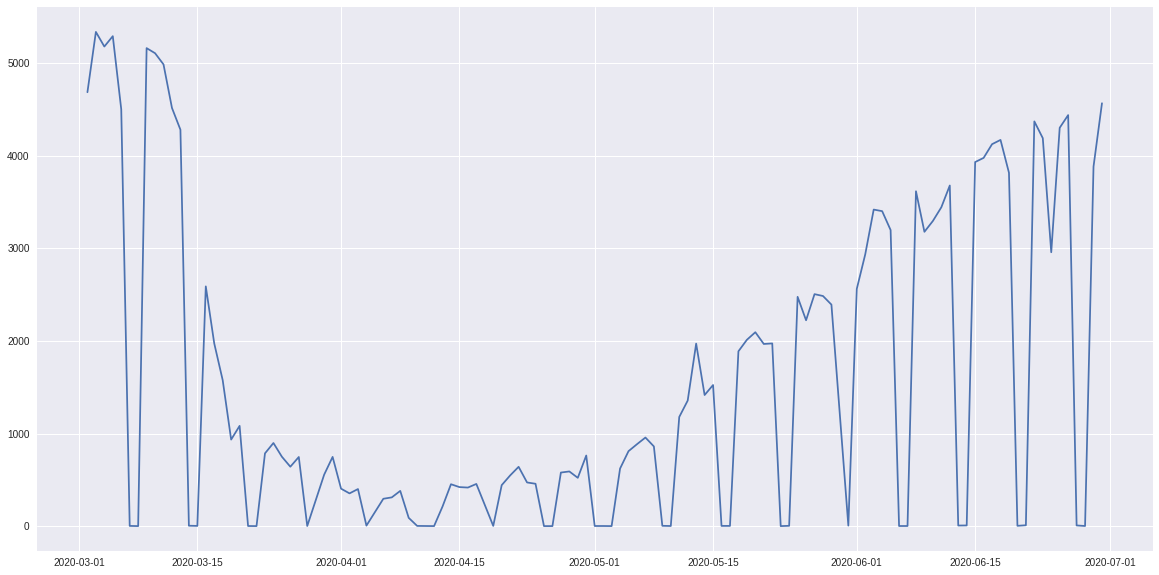

In [45]:
fig, ax = plt.subplots(figsize=(20,10))
grouped = df.groupby(['FEC_TRAMITE']).size().reset_index(name='counts')

plt.plot(
    grouped[(grouped['FEC_TRAMITE'] >= '2020-03-01') & (grouped['FEC_TRAMITE'] <= '2020-06-30')]['FEC_TRAMITE'],
    grouped[(grouped['FEC_TRAMITE'] >= '2020-03-01') & (grouped['FEC_TRAMITE'] <= '2020-06-30')]['counts'],
)


Al comparar el periodo con respecto al del año siguiente, así como la media en el mismo, se ve un decremento de un 50% de  las transacciones

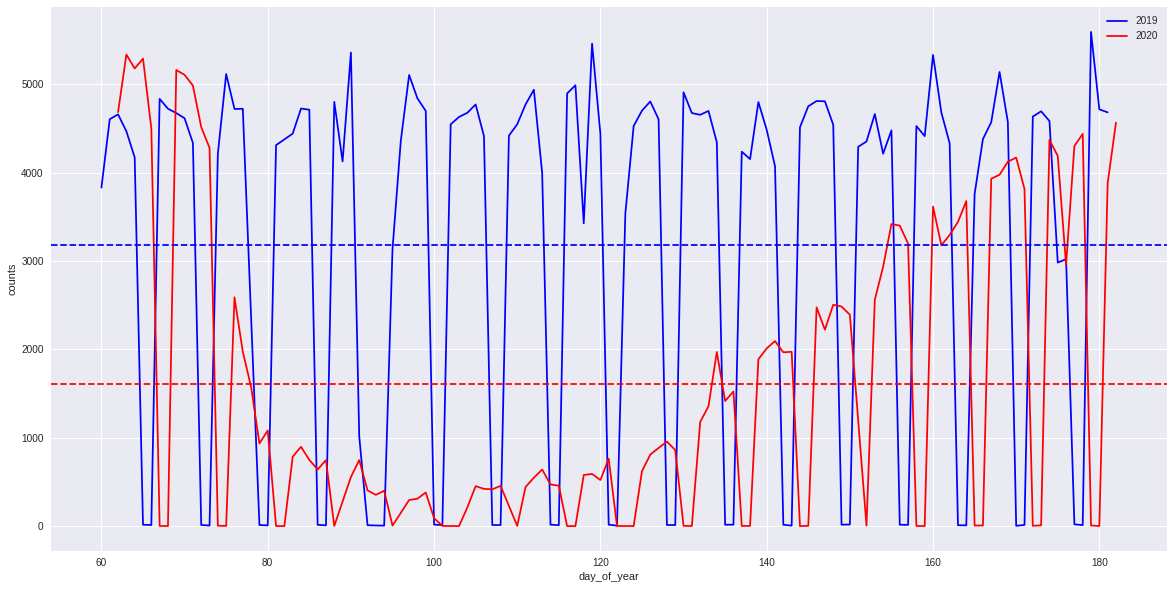

In [60]:

grouped = df.groupby(['FEC_TRAMITE']).size().reset_index(name='counts')

grouped['day_of_year'] = grouped['FEC_TRAMITE'].dt.dayofyear
grouped['year'] = grouped['FEC_TRAMITE'].dt.year

fig, ax = plt.subplots(figsize=(20,10))

#2021 -> blue
sns.lineplot(data=grouped[(grouped['FEC_TRAMITE'] >= '2021-03-01') & (grouped['FEC_TRAMITE'] <= '2021-06-30')], x='day_of_year', y='counts', color='blue', label='2019')
#2020 -> red
sns.lineplot(data=grouped[(grouped['FEC_TRAMITE'] >= '2020-03-01') & (grouped['FEC_TRAMITE'] <= '2020-06-30')], x='day_of_year', y='counts', color='red', label='2020')




plt.axhline(
    y = grouped[(grouped['FEC_TRAMITE'] >= '2020-03-01') & (grouped['FEC_TRAMITE'] <= '2020-06-30')]['counts'].describe()['mean'],
    color = 'r',
    linestyle = '--'
)

plt.axhline(
    y = grouped[(grouped['FEC_TRAMITE'] >= '2021-03-01') & (grouped['FEC_TRAMITE'] <= '2021-06-30')]['counts'].describe()['mean'],
    color = 'b',
    linestyle = '--'
)




In [58]:
mean_2021 = grouped[(grouped['FEC_TRAMITE'] >= '2021-03-01') & (grouped['FEC_TRAMITE'] <= '2021-06-30')]['counts'].describe()['mean']
mean_2020 = grouped[(grouped['FEC_TRAMITE'] >= '2020-03-01') & (grouped['FEC_TRAMITE'] <= '2020-06-30')]['counts'].describe()['mean']


percent = mean_2020 * 100 /  mean_2021
percent

50.517224077730404

Al fijarnos en la distribución de transacciones de un mes cualquiera vemos que hay una frecuencia reseñable. En los fines de semana las transacciones tienden a 0, a casi no haber ninguna.

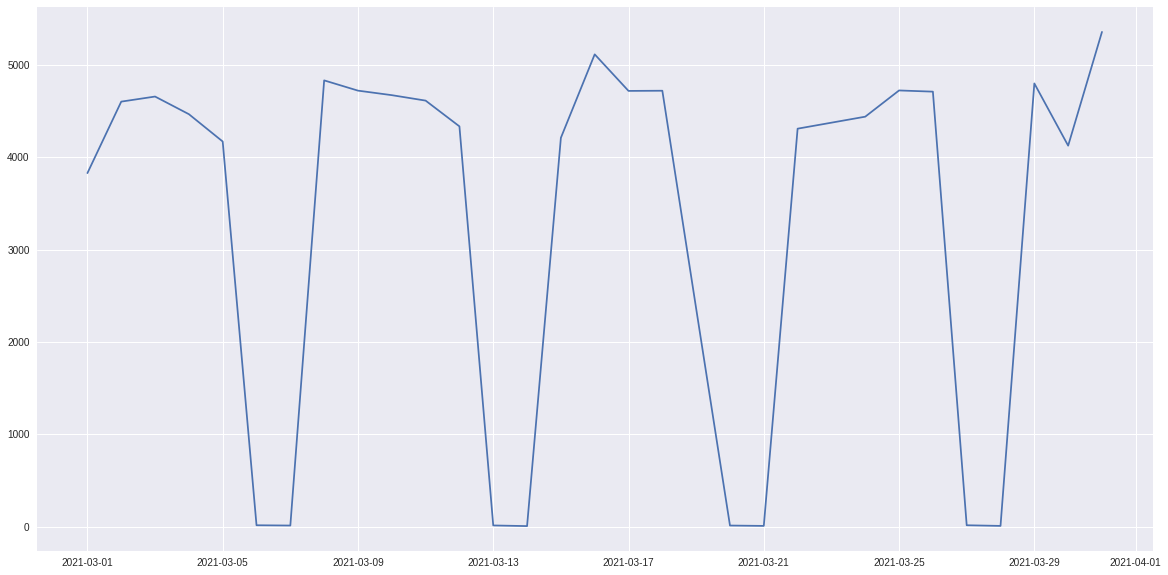

In [20]:
fig, ax = plt.subplots(figsize=(20,10))
grouped = df.groupby(['FEC_TRAMITE']).size().reset_index(name='counts')

plt.plot(
    grouped[(grouped['FEC_TRAMITE'] >= '2021-03-01') & (grouped['FEC_TRAMITE'] <= '2021-03-31')]['FEC_TRAMITE'],
    grouped[(grouped['FEC_TRAMITE'] >= '2021-03-01') & (grouped['FEC_TRAMITE'] <= '2021-03-31')]['counts']
)

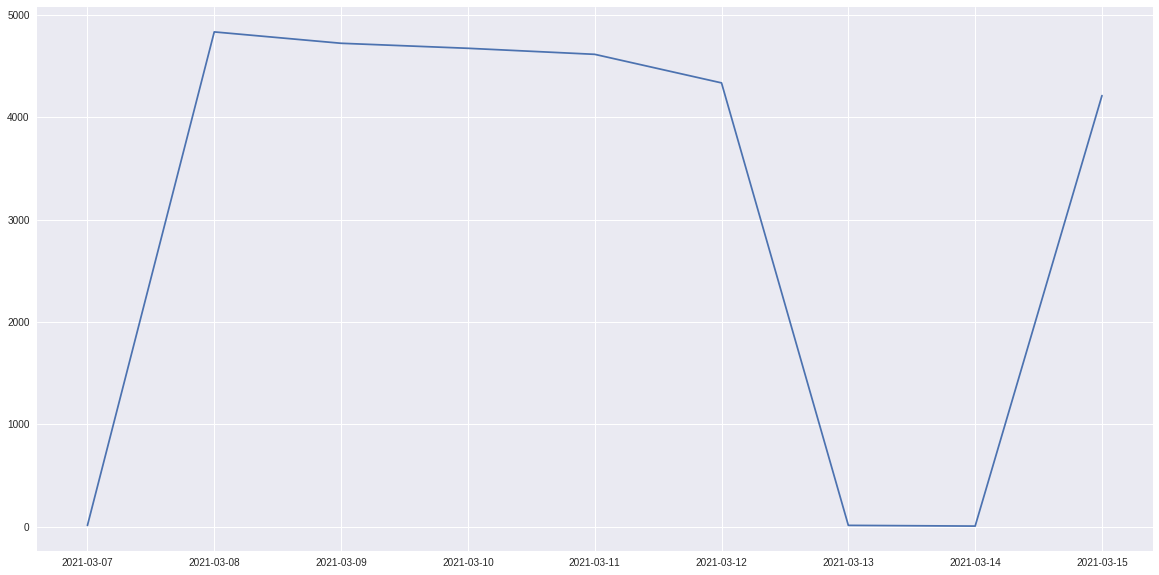

In [21]:
fig, ax = plt.subplots(figsize=(20,10))
grouped = df.groupby(['FEC_TRAMITE']).size().reset_index(name='counts')

plt.plot(
    grouped[(grouped['FEC_TRAMITE'] >= '2021-03-07') & (grouped['FEC_TRAMITE'] <= '2021-03-15')]['FEC_TRAMITE'],
    grouped[(grouped['FEC_TRAMITE'] >= '2021-03-07') & (grouped['FEC_TRAMITE'] <= '2021-03-15')]['counts']
)

Si contabilizamos las ventas de todo el periodo del dataset, es más claro que los fines de semana apenas quedan registradas transacciones.

In [22]:
df['day_of_week'] = df['FEC_TRAMITE'].dt.day_name()
df.groupby(['day_of_week']).size().reset_index(name='counts')

,day_of_week,counts
0,Friday,1393702
1,Monday,1449369
2,Saturday,2997
3,Sunday,1879
4,Thursday,1531689
5,Tuesday,1529877
6,Wednesday,1549195


Por lo que, para facilitar la obtención de la serie temporal, es importante identificar los días que son fin de semana

In [23]:
def is_weekend(day_week):
    if (day_week == 'Saturday' or day_week == 'Sunday'):
        return True
    else:
        return False

In [24]:
df['day_of_week'].apply(lambda x: is_weekend(x))

2206206    False
493451     False
2265822    False
606995     False
1850653    False
           ...  
824744     False
1766498    False
1631001    False
2031380    False
2022509    False
Name: day_of_week, Length: 7458708, dtype: bool

In [25]:
df['is_weekend'] = df['day_of_week'].apply(lambda x: is_weekend(x))

### 2.2 Marcas

Otra forma de centrar las transaciones son las marcas de los turismos.

In [63]:
df.groupby(['MARCA_ITV']).size().reset_index(name='counts').sort_values('counts', ascending=False).head(10)

,MARCA_ITV,counts
51,SEAT,701857
47,RENAULT,695389
60,VOLKSWAGEN,657497
45,PEUGEOT,654896
8,CITROEN,623449
44,OPEL,539059
18,FORD,526366
4,BMW,427688
2,AUDI,408304
39,MERCEDES-BENZ,406003


Podemos ver la evolución de las marcas de las que más traspasos se hacen y ver su evolución en el periodo

In [28]:
df.groupby(['MARCA_ITV','year_Q']).size().reset_index(name='counts')

,MARCA_ITV,year_Q,counts
0,ALFA ROMEO,2015,1
1,ALFA ROMEO,2016,78
2,ALFA ROMEO,2017,53
3,ALFA ROMEO,2018,57
4,ALFA ROMEO,2019,52
...,...,...,...
416,VOLVO,2017,12702
417,VOLVO,2018,13153
418,VOLVO,2019,13381
419,VOLVO,2020,11160


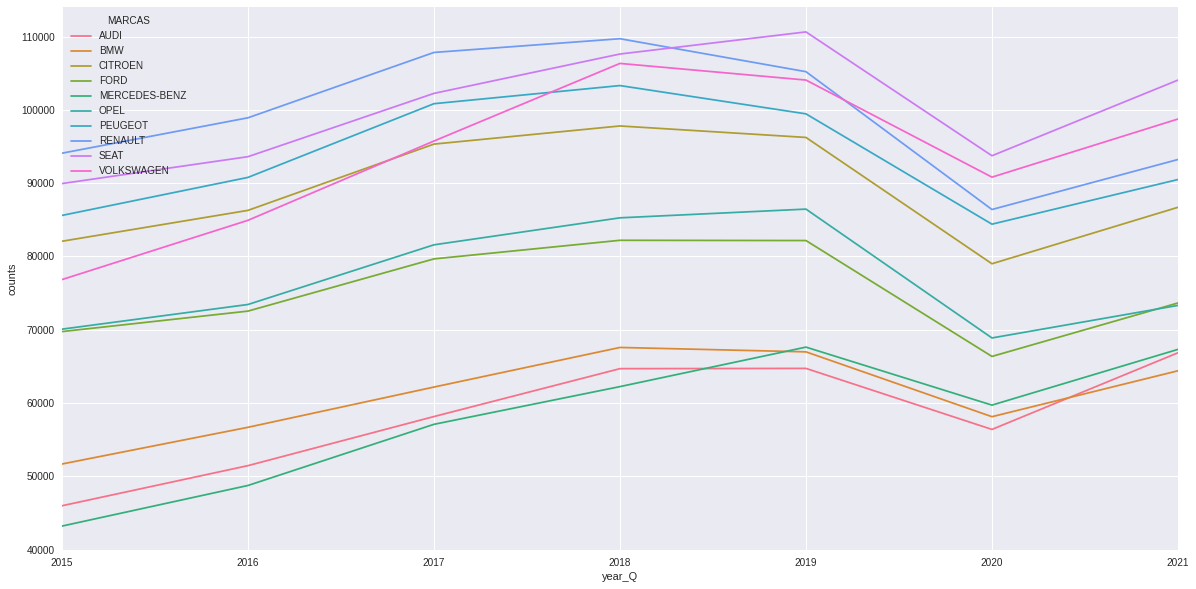

In [74]:
fig, ax = plt.subplots(figsize=(20,10))
grouped = df.groupby(['MARCA_ITV','year_Q']).size().reset_index(name='counts')

sns.lineplot(data=grouped[grouped['MARCA_ITV'].isin(
        df.groupby(['MARCA_ITV']).size().reset_index(name='counts').sort_values('counts', ascending=False).head(10)['MARCA_ITV']
    ) ], x='year_Q', y='counts', hue='MARCA_ITV', legend='full')
ax.set_xlim([2015,2021])
ax.legend(title='MARCAS')

En el gráfico se puede apreciar la evolución de la evolución de las trasacciones por las marcas más "transaccionadas". Se puede ver como SEAT ha ido en aumento, superando al resto de marcas en 2019. También se comprueba la bajada de ventas en 2020 por el confinamiento.

### 2.3 Provincias

Se puede observar que Madrid se lleva la palma en lo que a transacciones de vehículos se refiere. Barcelona va por debajo por unos cuantos cientos de miles. Pero el salto importante se aprecia con respecto al tercer puesto, como se podrá ver mejor en la gráfica, la diferencia es de casi tres veces más.  

In [30]:
df.groupby(['ID_MUNICIPIO']).size().reset_index(name='counts').sort_values('counts', ascending=False).head(10)

,ID_MUNICIPIO,counts
27,28,1114125
7,08,849058
45,46,371211
2,03,306171
40,41,298008
28,29,269825
29,30,250708
6,07,198167
44,45,193540
34,35,176346


In [31]:
df.groupby(['ID_MUNICIPIO','year_Q']).size().reset_index(name='counts').sort_values('counts', ascending=False)

,ID_MUNICIPIO,year_Q,counts
193,28,2019,176342
195,28,2021,176094
192,28,2018,175033
191,28,2017,159155
194,28,2020,153248
...,...,...,...
354,51,2019,1583
287,42,2015,1580
362,52,2020,1436
356,51,2021,1432


In [75]:
df['province'] = df['ID_MUNICIPIO'].apply(lambda x: return_province(x))

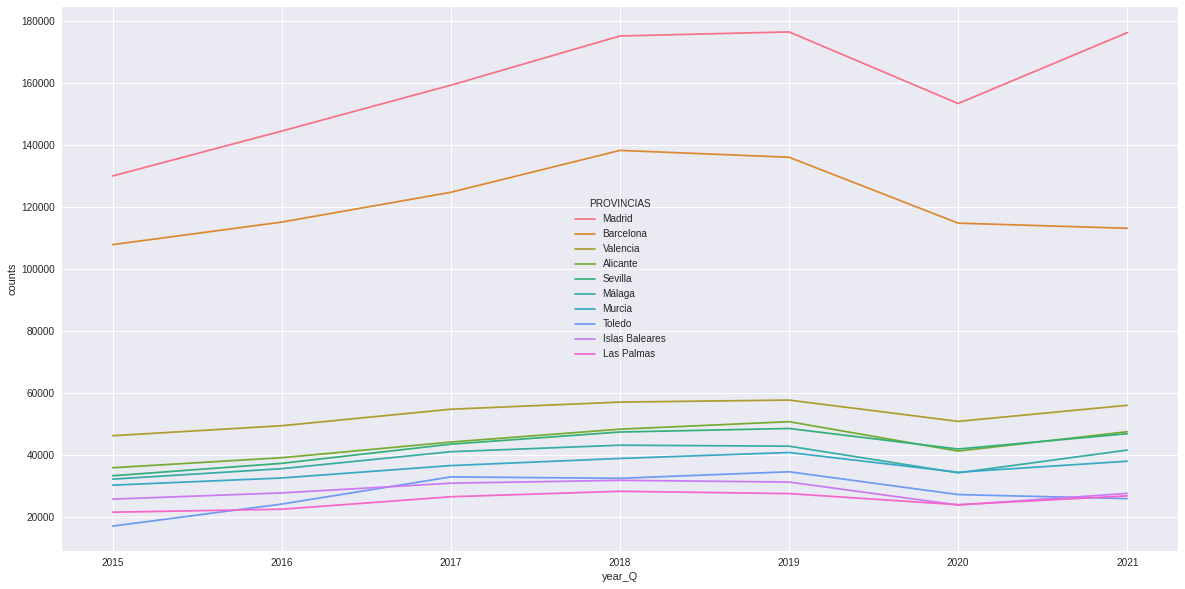

In [76]:
fig, ax = plt.subplots(figsize=(20,10))

grouped = df.groupby(['province','year_Q']).size().reset_index(name='counts').sort_values('counts', ascending=False)

sns.lineplot(data=grouped[grouped['province'].isin(
        df.groupby(['province']).size().reset_index(name='counts').sort_values('counts', ascending=False).head(10)['province']
    ) ], x='year_Q', y='counts', hue='province', legend='full')
ax.legend(title='PROVINCIAS')

### 2.4 Persona Juridica-Física

Esta columna hace referencia a que si el dueño del vehículo es una persona física o juridica. Este valor es ideal para comprobar si el destino del vehículo es una persona o una empresa

In [77]:
df.groupby(['PERSONA_FISICA_JURIDICA']).size().reset_index(name='counts').sort_values('counts', ascending=False)

,PERSONA_FISICA_JURIDICA,counts
0,D,5979533
1,X,1479175


<AxesSubplot:xlabel='PERSONA_FISICA_JURIDICA'>

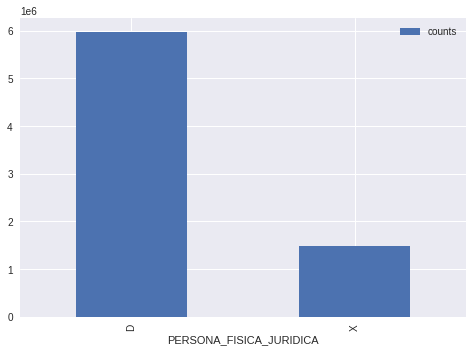

In [78]:
df.groupby(['PERSONA_FISICA_JURIDICA']).size().reset_index(name='counts').sort_values('counts', ascending=False).plot.bar(x='PERSONA_FISICA_JURIDICA')

In [79]:
df.groupby(['year_Q', 'PERSONA_FISICA_JURIDICA']).size().reset_index(name='counts')

,year_Q,PERSONA_FISICA_JURIDICA,counts
0,2015,D,797783
1,2015,X,109522
2,2016,D,799562
3,2016,X,181958
4,2017,D,863662
5,2017,X,232626
6,2018,D,912307
7,2018,X,259201
8,2019,D,926890
9,2019,X,258696


In [80]:
df.groupby(['year_Q','ID_MUNICIPIO','PERSONA_FISICA_JURIDICA']).size().reset_index(name='counts')

,year_Q,ID_MUNICIPIO,PERSONA_FISICA_JURIDICA,counts
0,2015,01,D,5534
1,2015,01,X,1244
2,2015,02,D,6162
3,2015,02,X,633
4,2015,03,D,32190
...,...,...,...,...
723,2021,50,X,3536
724,2021,51,D,1405
725,2021,51,X,27
726,2021,52,D,1600


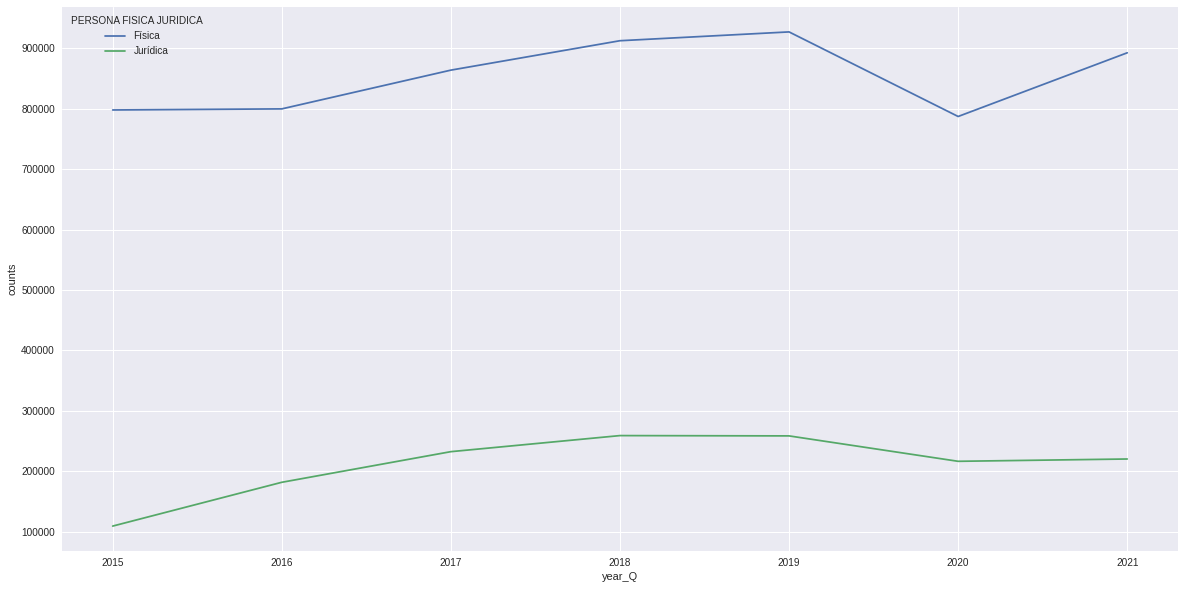

In [81]:
fig, ax = plt.subplots(figsize=(20,10))
grouped = df.groupby(['year_Q', 'PERSONA_FISICA_JURIDICA']).size().reset_index(name='counts')

grouped['LITERAL_FISICA_JURIDICA'] = grouped['PERSONA_FISICA_JURIDICA'].apply(lambda x: 'Jurídica' if x == 'X' else 'Física')

sns.lineplot(data=grouped, x='year_Q', y='counts', hue='LITERAL_FISICA_JURIDICA', legend='full')

ax.legend(title='PERSONA FISICA JURIDICA')

Podemos ver una tendencia de unas marcas frente a otras dependiendo del tipo de persona

In [87]:
grouped = df.groupby(['PERSONA_FISICA_JURIDICA','MARCA_ITV']).size().reset_index(name='counts')
grouped[grouped['PERSONA_FISICA_JURIDICA'] == 'D'].sort_values('counts', ascending=False).head(10)

,PERSONA_FISICA_JURIDICA,MARCA_ITV,counts
47,D,RENAULT,587970
51,D,SEAT,582267
60,D,VOLKSWAGEN,535062
45,D,PEUGEOT,532730
8,D,CITROEN,514019
44,D,OPEL,450638
18,D,FORD,439089
4,D,BMW,331936
2,D,AUDI,319294
39,D,MERCEDES-BENZ,305647


In [85]:
grouped = df.groupby(['PERSONA_FISICA_JURIDICA','MARCA_ITV']).size().reset_index(name='counts')
grouped[grouped['PERSONA_FISICA_JURIDICA'] == 'X'].sort_values('counts', ascending=False).head(10)

,PERSONA_FISICA_JURIDICA,MARCA_ITV,counts
122,X,VOLKSWAGEN,122435
107,X,PEUGEOT,122166
113,X,SEAT,119590
70,X,CITROEN,109430
109,X,RENAULT,107419
101,X,MERCEDES-BENZ,100356
66,X,BMW,95752
64,X,AUDI,89010
106,X,OPEL,88421
80,X,FORD,87277


### 2.5 Número de Plazas

Este campo es desconcertante. El dataset está filtrado por vehículos de tipo turismo en el notebook previo a este, por lo que la variación de asientos es sorprendete. Aquí puede deberse a un factor humano en los casos más extremos, y ha turismos de carácteristicas especiales en otros. Es claro que la mayoría de turismos dispone de 5 plazas

In [88]:
df.groupby(['NUM_PLAZAS']).size().reset_index(name='counts')

,NUM_PLAZAS,counts
0,0,243
1,1,334
2,2,68829
3,3,2005
4,4,484567
5,5,6481748
6,6,12119
7,7,371896
8,8,22858
9,9,14106


<AxesSubplot:>

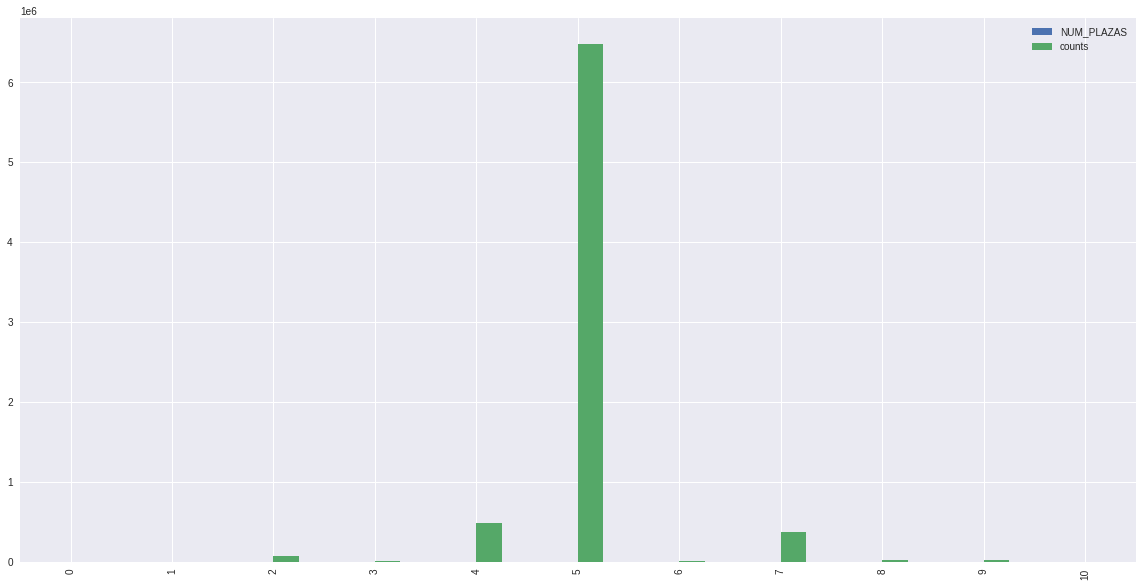

In [89]:
fig, ax = plt.subplots(figsize=(20,10))
df.groupby(['NUM_PLAZAS']).size().reset_index(name='counts').plot.bar(ax=ax)

### 2.6 Cilindrada

Se define cilindrada como "Es la suma del volumen útil de todos los cilindros. Suele medirse en centímetros cúbicos (cm3), aunque también es usual su equivalencia en litros (2500 cm3 = 2,5 litros)". La mayoría de los vehículos gira en torno a los 1500-2000 cm3

In [90]:
df.groupby(['CILINDRADA_ITV']).size().reset_index(name='counts')

,CILINDRADA_ITV,counts
0,0,13381
1,1,104
2,4,6
3,5,1
4,6,1
...,...,...
3015,9997,1
3016,9999,4
3017,10000,1
3018,12890,1


In [91]:
bins = [0, 10, 100, 500, 1000, 5000, 10000, 25000]

df['CILINDRADA_ITV'].value_counts(bins=bins, sort=False).reset_index()

,index,CILINDRADA_ITV
0,"(-0.001, 10.0]",13493
1,"(10.0, 100.0]",2
2,"(100.0, 500.0]",530
3,"(500.0, 1000.0]",384971
4,"(1000.0, 5000.0]",7051236
5,"(5000.0, 10000.0]",8474
6,"(10000.0, 25000.0]",1


<AxesSubplot:xlabel='index'>

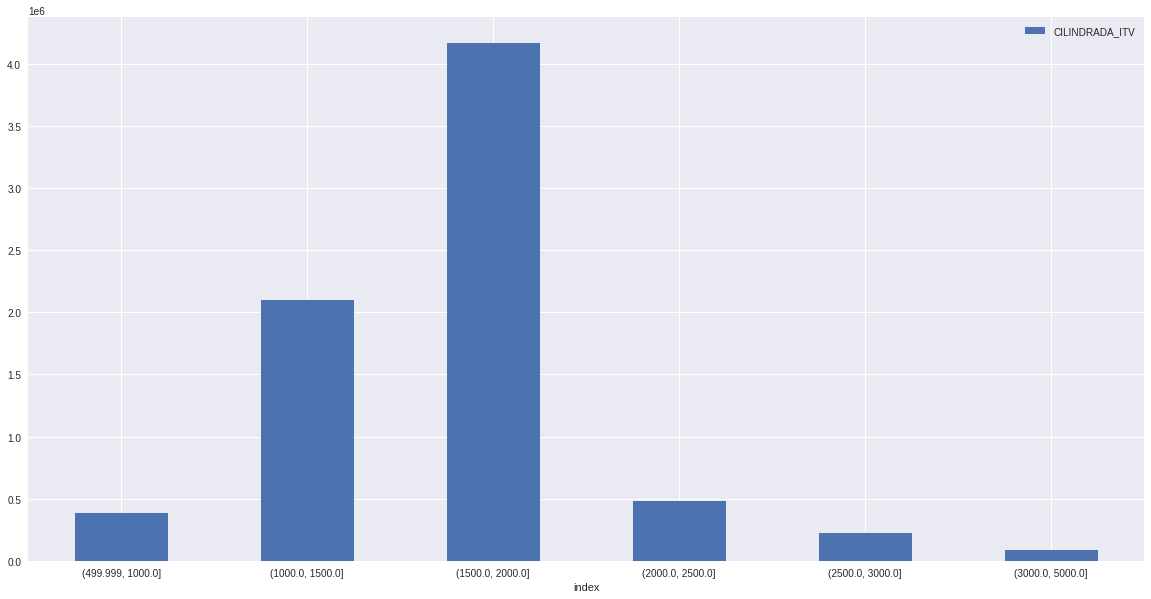

In [92]:
fig, ax = plt.subplots(figsize=(20,10))

bins = [500, 1000, 1500, 2000, 2500, 3000, 5000]

df['CILINDRADA_ITV'].value_counts(bins=bins, sort=False).reset_index().plot.bar(x='index', y='CILINDRADA_ITV', rot=0, ax=ax)


### 2.7 Potencia

A diferencia de la cilindrada, la potencia de un turismo está más repartida

In [93]:
df.groupby(['POTENCIA_ITV']).size().reset_index(name='counts')

,POTENCIA_ITV,counts
0,0.00,5
1,0.01,20
2,0.02,7
3,0.03,2
4,0.04,9
...,...,...
2815,135.80,1
2816,152.20,1
2817,190.95,1
2818,411.64,1


In [94]:
bins = [0, 10, 15, 25, 30, 35, 40, 45, 50]

df['POTENCIA_ITV'].value_counts(bins=bins, sort=False).reset_index()

,index,POTENCIA_ITV
0,"(-0.001, 10.0]",1245119
1,"(10.0, 15.0]",5732504
2,"(15.0, 25.0]",441637
3,"(25.0, 30.0]",22490
4,"(30.0, 35.0]",13785
5,"(35.0, 40.0]",2563
6,"(40.0, 45.0]",260
7,"(45.0, 50.0]",89


<AxesSubplot:xlabel='index'>

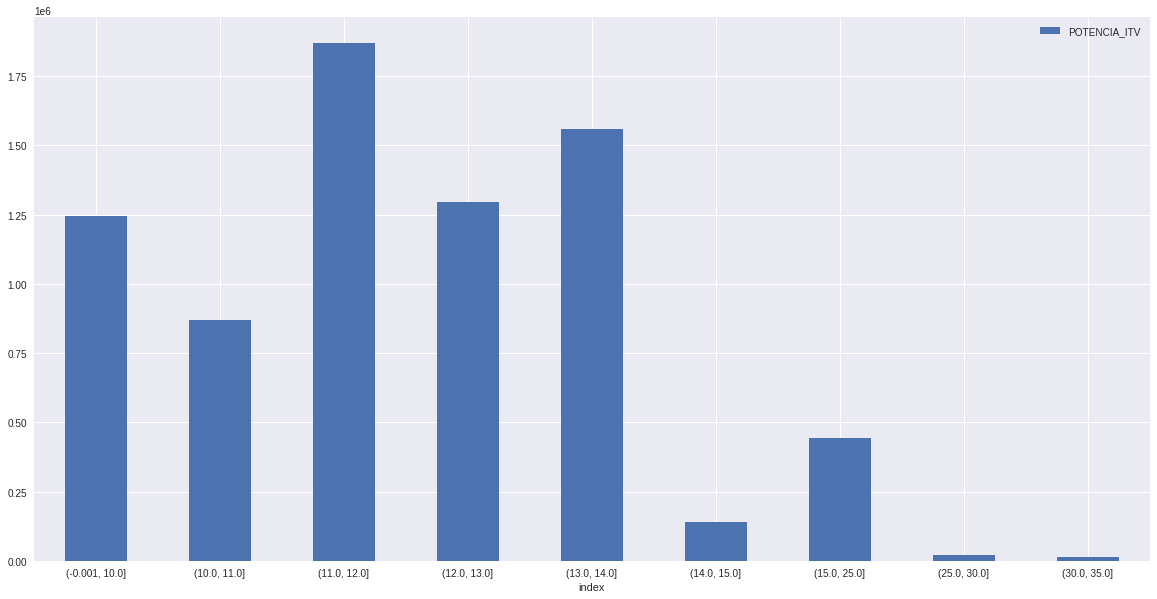

In [95]:
fig, ax = plt.subplots(figsize=(20,10))

bins = [0, 10, 11, 12, 13, 14, 15, 25, 30, 35]

df['POTENCIA_ITV'].value_counts(bins=bins, sort=False).reset_index().plot.bar(x='index', y='POTENCIA_ITV', rot=0, ax=ax)


### 2.8 Emisiones CO2

Como el nombre indica, hace referencia a las emisiones de CO2 que expulsa el coche

In [101]:
df.groupby(['CO2_ITV']).size().reset_index(name='counts')

,CO2_ITV,counts
0,1.0,422
1,2.0,7
2,3.0,4
3,4.0,13
4,5.0,22
...,...,...
452,980.0,3
453,989.0,1
454,990.0,19
455,998.0,1


<AxesSubplot:xlabel='index'>

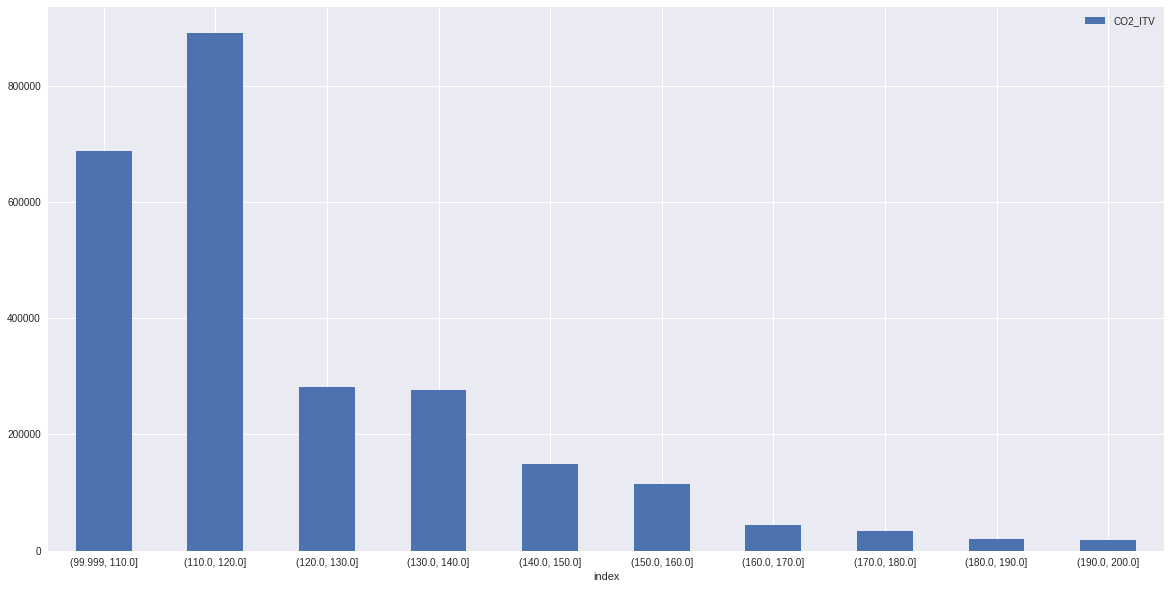

In [102]:
fig, ax = plt.subplots(figsize=(20,10))

bins = [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]

df['CO2_ITV'].value_counts(bins=bins, sort=False).reset_index().plot.bar(x='index', y='CO2_ITV', rot=0, ax=ax)


Podemos diferenciar las marcas más contaminantes para hacer una comparativa. Es apreciable que los más contaminantes son marcas americanas o de lujo

In [107]:
df.groupby(['MARCA_ITV'])['CO2_ITV'].agg('mean').reset_index().sort_values('CO2_ITV', ascending=False).head(10)

,MARCA_ITV,CO2_ITV
19,GMC,338.200000
30,LAMBORGHINI,336.530120
3,BENTLEY,325.690096
16,FERRARI,310.197655
1,ASTON MARTIN,305.921687
38,MCLAREN,264.512821
5,CADILLAC,244.736111
21,HUMMER,234.636364
36,MASERATI,226.895128
7,CHRYSLER,216.010462


<AxesSubplot:xlabel='MARCA_ITV'>

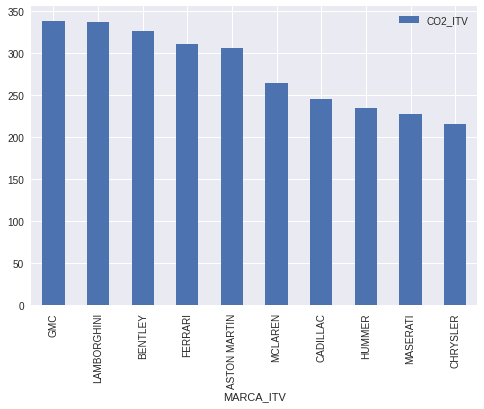

In [108]:
 df.groupby(['MARCA_ITV'])['CO2_ITV'].agg('mean').reset_index().sort_values('CO2_ITV', ascending=False).head(10).plot.bar(x='MARCA_ITV')

### 2.9 Renting

Vehículo de renting o de compra tradicional. No es un campo relevante ya que en este país el renting es minoritario

In [110]:
df.groupby(['RENTING']).size().reset_index(name='counts')

,RENTING,counts
0,N,7393461
1,S,15627


<AxesSubplot:xlabel='RENTING'>

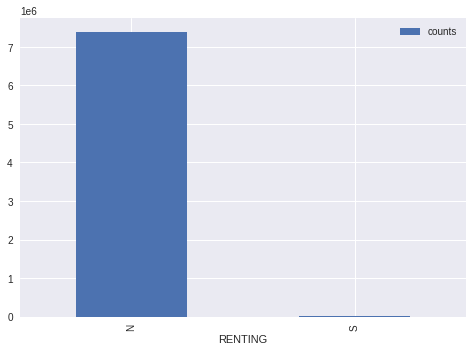

In [111]:
df.groupby(['RENTING']).size().reset_index(name='counts').sort_values('counts', ascending=False).plot.bar(x='RENTING')

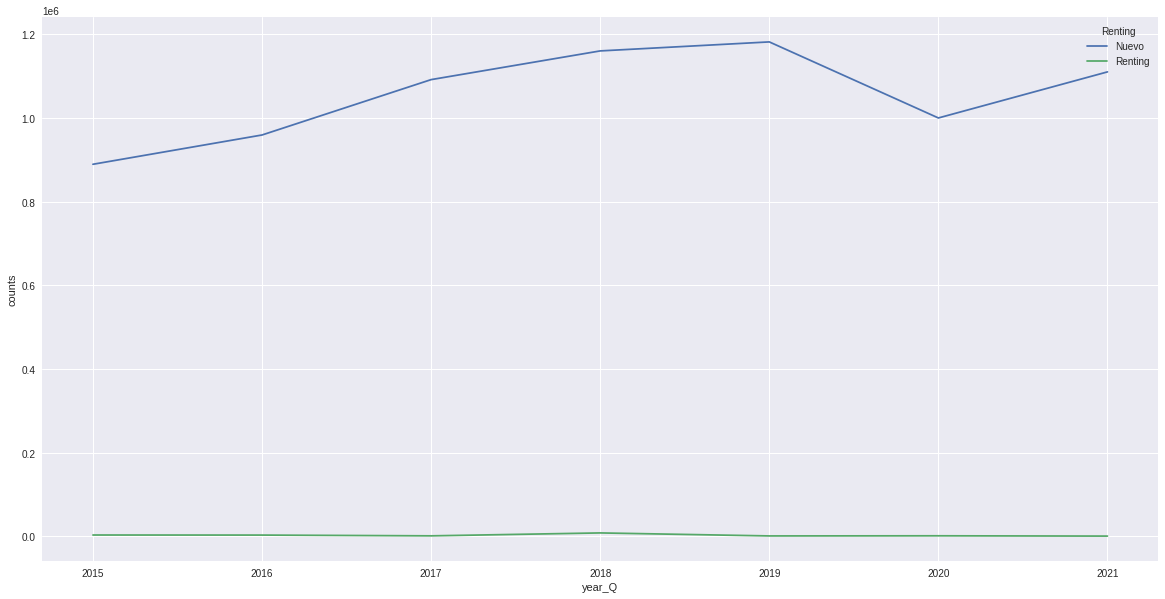

In [112]:
fig, ax = plt.subplots(figsize=(20,10))
grouped = df.groupby(['year_Q', 'RENTING']).size().reset_index(name='counts')

grouped['LITERAL_RENTING'] = grouped['RENTING'].apply(lambda x: 'Nuevo' if x == 'N' else 'Renting')

sns.lineplot(data=grouped, x='year_Q', y='counts', hue='LITERAL_RENTING', legend='full')

ax.legend(title='Renting')

### 2.10 Homologación Europea

La inmensa mayoría de los vehículos de este dataset tiene categoría M1

In [113]:
df.groupby(['CATEGORÍA_HOMOLOGACIÓN_EUROPEA_ITV']).size().reset_index(name='counts')

,CATEGORÍA_HOMOLOGACIÓN_EUROPEA_ITV,counts
0,*74,3
1,1000,1
2,ATV,5
3,L3E,14
4,L3e,1
5,L4E,16
6,L6E,1
7,L7E,1
8,M1,6630220
9,M1G,1752


### 2.11 Nivel de emisiones

In [116]:
df.groupby(['NIVEL_EMISIONES_EURO_ITV']).size().reset_index(name='counts').sort_values('counts', ascending=False).head(10)

,NIVEL_EMISIONES_EURO_ITV,counts
438,EURO 3,1771988
454,EURO 4,1501233
432,EURO 2,795980
671,EURO 6W,747530
479,EURO 5,635241
605,EURO 6 W,209665
585,EURO 6,204610
424,EURO 1,201170
569,EURO 5J,192307
633,EURO 6AG,170468


<AxesSubplot:xlabel='NIVEL_EMISIONES_EURO_ITV'>

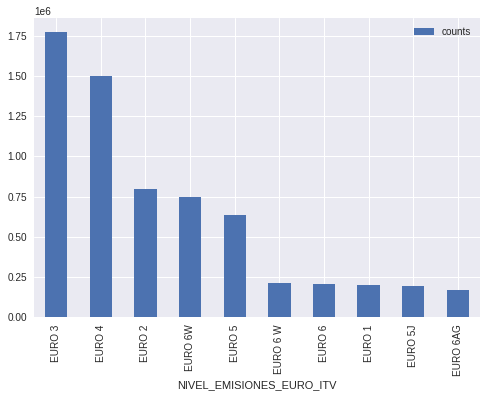

In [119]:
df.groupby(['NIVEL_EMISIONES_EURO_ITV']).size().reset_index(name='counts').sort_values('counts', ascending=False).head(10).plot.bar(x='NIVEL_EMISIONES_EURO_ITV')

### 2.12 Vehículo Eléctrico y autonomía

- PHEV Eléctrico Enchufable
- REEV Eléctrico de Autonomía Extendida
- HEV Eléctrico Híbrido
- BEV Eléctrico de Batería

In [120]:
df.groupby(['CATEGORÍA_VEHÍCULO_ELÉCTRICO']).size().reset_index(name='counts')

,CATEGORÍA_VEHÍCULO_ELÉCTRICO,counts
0,BEV,12579
1,FCEV,1
2,HEV,88859
3,PHEV,9390
4,REEV,756


<AxesSubplot:xlabel='CATEGORÍA_VEHÍCULO_ELÉCTRICO'>

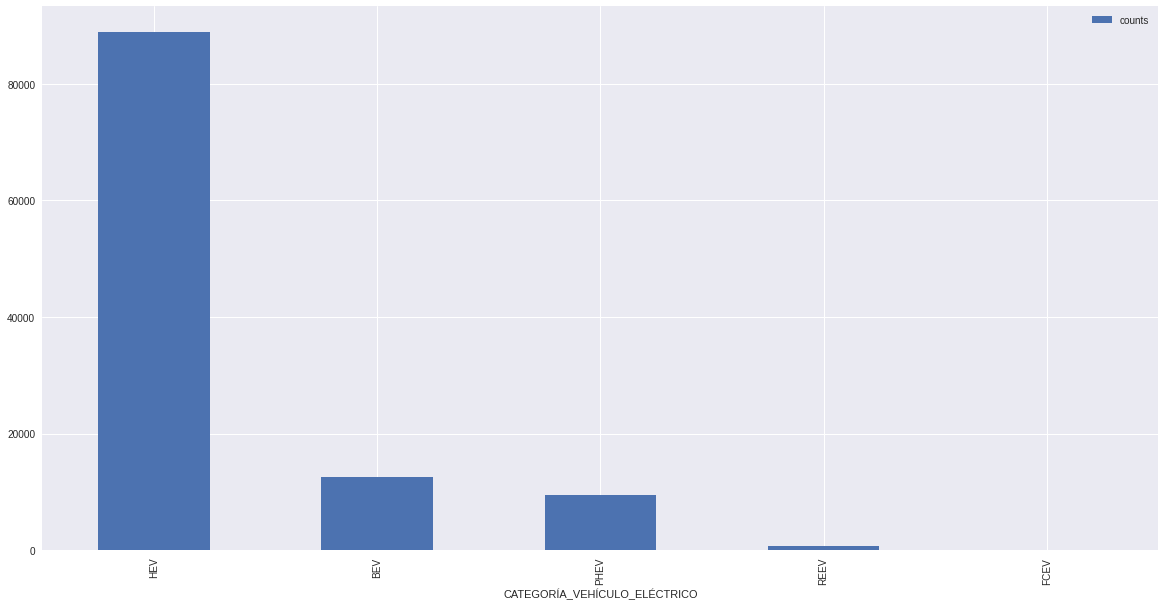

In [121]:
fig, ax = plt.subplots(figsize=(20,10))


df.groupby(['CATEGORÍA_VEHÍCULO_ELÉCTRICO']).size().reset_index(name='counts').sort_values('counts', ascending=False).plot.bar(x='CATEGORÍA_VEHÍCULO_ELÉCTRICO', ax=ax)

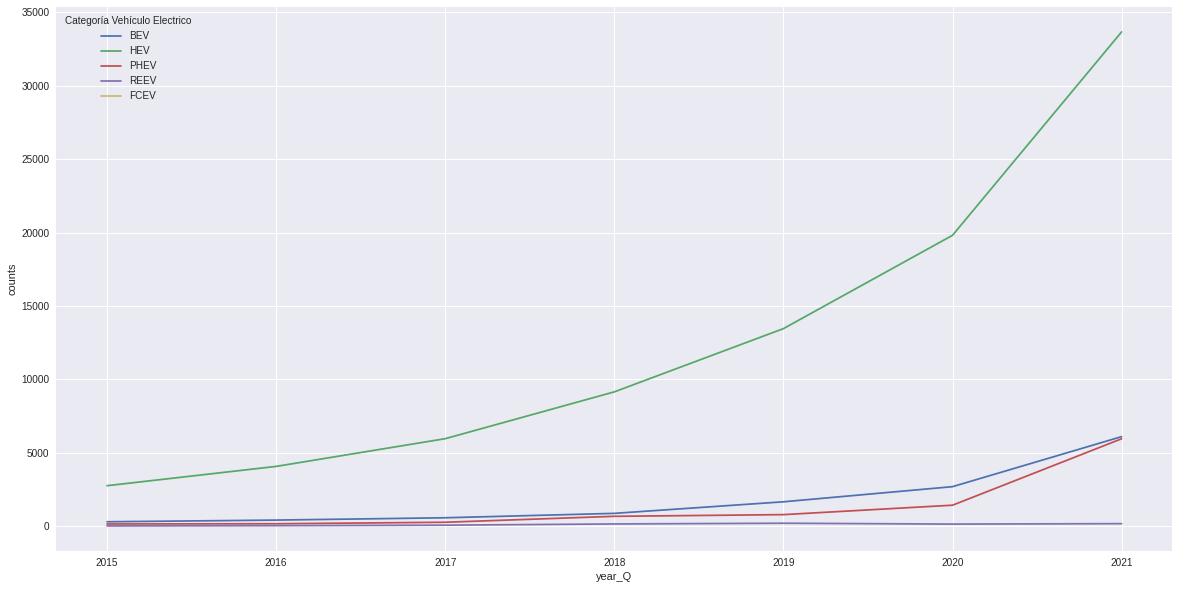

In [122]:
fig, ax = plt.subplots(figsize=(20,10))
grouped = df.groupby(['year_Q', 'CATEGORÍA_VEHÍCULO_ELÉCTRICO']).size().reset_index(name='counts')

sns.lineplot(data=grouped, x='year_Q', y='counts', hue='CATEGORÍA_VEHÍCULO_ELÉCTRICO', legend='full')

ax.legend(title='Categoría Vehículo Electrico')

# PHEV Eléctrico Enchufable
# REEV Eléctrico de Autonomía Extendida
# HEV Eléctrico Híbrido
# BEV Eléctrico de Batería

In [123]:
df.groupby(['AUTONOMÍA_VEHÍCULO_ELÉCTRICO']).size().reset_index(name='counts')

,AUTONOMÍA_VEHÍCULO_ELÉCTRICO,counts
0,0.0,2263636
1,100.0,120
2,200.0,5
3,400.0,3
4,1300.0,1
...,...,...
353,61400.0,2
354,62400.0,8
355,63200.0,35
356,64000.0,1


In [124]:
bins = [1000, 5000, 10000, 15000, 20000]

df['AUTONOMÍA_VEHÍCULO_ELÉCTRICO'].value_counts(bins=bins, sort=False).reset_index()

,index,AUTONOMÍA_VEHÍCULO_ELÉCTRICO
0,"(999.999, 5000.0]",3135
1,"(5000.0, 10000.0]",6243
2,"(10000.0, 15000.0]",1771
3,"(15000.0, 20000.0]",3985


<AxesSubplot:xlabel='index'>

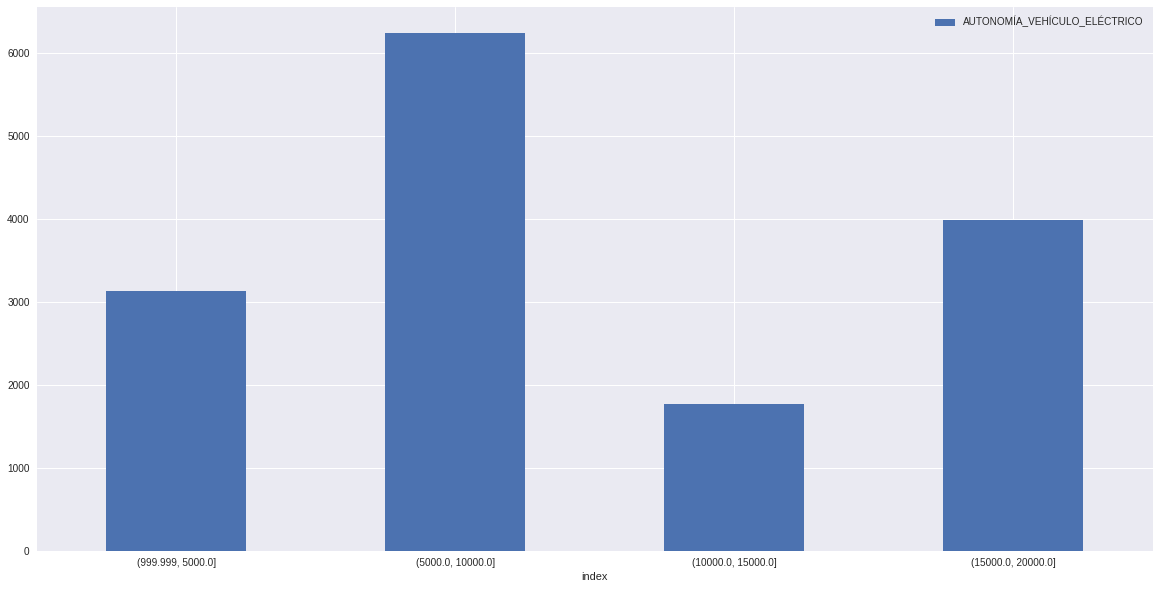

In [125]:
fig, ax = plt.subplots(figsize=(20,10))

bins = [1000, 5000, 10000, 15000, 20000]

df['AUTONOMÍA_VEHÍCULO_ELÉCTRICO'].value_counts(bins=bins, sort=False).reset_index().plot.bar(x='index', y='AUTONOMÍA_VEHÍCULO_ELÉCTRICO', rot=0, ax=ax)